## The following notebook demonstrates how to load neural data for all experiments in a given ophys/behavior session into a single 'tidy' dataframe, make some simple event-triggered plots, then do a basic decoding analysis

### This is designed to demonstrate a simple method for interacting with the visual behavior data. Many aspects of the dataset are not explored here.

## Imports
In addition to some standard packages, both visual_behavior_analysis and the AllenSDK need to be installed

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tqdm import tqdm

import allensdk.brain_observatory.behavior.behavior_project_cache as bpc

from visual_behavior.data_access import utilities
import visual_behavior.utilities as vbu

pd.set_option('display.max_columns', 500)

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load the session and experiment summary tables

In [3]:
data_storage_directory = "~\temp" # Note: this path must exist on your local drive
cache = bpc.VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

In [4]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

In [5]:
experiment_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085394308
951980484,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028351,VisualBehaviorMultiscope,75,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400876
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400919
951980479,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028354,VisualBehaviorMultiscope,150,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400977
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400920


## Load one example session
We are going to select one session from this table, session 854060305. This is a session with Sst-IRES-Cre mouse, which expressed GCaMP6f in Sst+ inhibitory interneurons. There were 6 simultaneously acquired imaging planes for this session. 
We can view metadata for this session as follows:

In [6]:
ophys_session_id = 854060305
session_table.loc[ophys_session_id]

equipment_name                                                                MESO.1
full_genotype                          Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
mouse_id                                                                      440631
reporter_line                                             Ai148(TIT2L-GC6f-ICL-tTA2)
driver_line                                                           [Sst-IRES-Cre]
sex                                                                                M
age_in_days                                                                      129
cre_line                                                                Sst-IRES-Cre
indicator                                                                    GCaMP6f
session_number                                                                     6
prior_exposures_to_session_type                                                    0
prior_exposures_to_image_set                                     

##  Each session consists of one or more 'experiments', in which each experiment is a single imaging plane

Each mesoscope session has up to 8 experiments associated with the session. We will load all sessions into a dictionary with the experiment IDs as the keys

The first time that this cell is run, the associated NWB files will be downloaded to your local `data_storage_directory`. Subsequent runs of this cell will be faster since the data will already be cached locally.

In [7]:
experiments = {}
ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

## Load neural data into memory
The cell below will load the neural data into memory in the 'tidy' format. It will also add some additional columns with some metadata to facilitate splitting by depth/structure.

In [8]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()):
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = utilities.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


In [9]:
len(neural_data)

2561543

In [10]:
neural_data.head()

,timestamps,cell_roi_id,cell_specimen_id,dff,events,filtered_events,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,10.52216,1080852071,1086550481,0.400583,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
1,10.61538,1080852071,1086550481,0.126125,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
2,10.70860,1080852071,1086550481,-0.083087,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
3,10.80182,1080852071,1086550481,0.158960,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
4,10.89504,1080852071,1086550481,0.301507,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M


## load the stimulus table
The stimulus table is shared across all experiments in a session. We can use just one.

In [11]:
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations
stimulus_table.head(10)

,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,,
0,0.25021,18001.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,17986,310.55053,310.80074,False
1,0.25020,18046.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,1,False,18031,311.30115,311.55135,False
2,0.25021,18091.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,2,False,18076,312.05179,312.30200,False
3,0.25020,18136.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,3,False,18121,312.80242,313.05262,False
4,0.25021,18181.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,4,False,18166,313.55303,313.80324,False
5,0.25023,18226.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,5,False,18211,314.30362,314.55385,False
6,0.25020,18271.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,6,False,18256,315.05426,315.30446,False
7,0.25020,18316.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,7,False,18301,315.80487,316.05507,False
8,0.25022,18361.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,8,False,18346,316.55547,316.80569,False


## Look at unique cells:

In [12]:
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

there are 53 unique cells
cell ids are: [1086550481 1086551114 1086551301 1086557083 1086557639 1086559064
 1086558114 1086558224 1086558510 1086559206 1086557304 1086557208
 1086560061 1086559681 1086559885 1086559968 1086557470 1086547796
 1086547993 1086548118 1086554566 1086556653 1086558574 1086552296
 1086558071 1086556532 1086555222 1086558701 1086557434 1086556317
 1086555835 1086549726 1086553836 1086551540 1086551151 1086550544
 1086552709 1086553271 1086553602 1086555553 1086548072 1086553899
 1086547630 1086549303 1086549491 1086549813 1086549949 1086548658
 1086548969 1086551457 1086551645 1086550990 1086551209]


## make an event triggered average for a single cell relative to stimulus omissions

In [13]:
cell_id = cell_ids[11]
etr = vbu.event_triggered_response(
    neural_data.query('cell_specimen_id == @cell_id'),
    parameter = 'dff',
    event_times = stimulus_table.query('omitted')['start_time'],
    t_before=3,
    t_after=3,
)
etr

,time,dff,event_number,event_time
0,-3.000000,0.043293,0,356.33793
1,-2.983333,0.043293,0,356.33793
2,-2.966667,0.043293,0,356.33793
3,-2.950000,0.041112,0,356.33793
4,-2.933333,0.028268,0,356.33793
...,...,...,...,...
66595,2.916667,0.005411,184,3911.29062
66596,2.933333,0.003929,184,3911.29062
66597,2.950000,0.002447,184,3911.29062
66598,2.966667,0.001321,184,3911.29062


## Plot the event triggered response with Seaborn

<AxesSubplot:xlabel='time', ylabel='dff'>

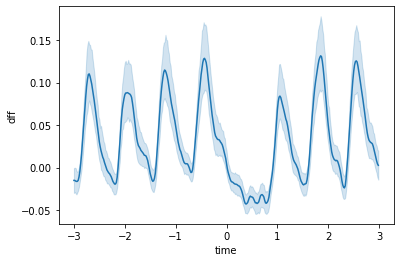

In [14]:
sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
)

## make a simple function so that the above can be done in a single line

In [15]:
def make_event_triggered_plot(df, x, y, event_query, ax, t_before=3, t_after=3):
    etr = vbu.event_triggered_response(
        df,
        parameter = y,
        event_times = stimulus_table.query(event_query)['start_time'],
        t_before=t_before,
        t_after=t_before,
    )
    sns.lineplot(
        data=etr,
        x=x,
        y=y,
        n_boot=500,
        ax=ax
    )

## repeat for events instead of dff

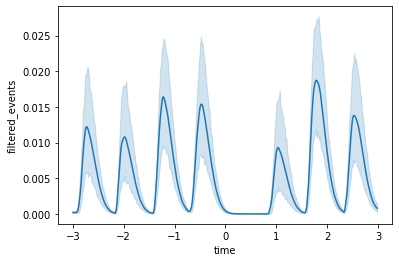

In [16]:
cell_id = cell_ids[11]
fig, ax = plt.subplots()
make_event_triggered_plot(
    df = neural_data.query('cell_specimen_id == @cell_id'), 
    x = 'time', 
    y = 'filtered_events', 
    event_query = 'omitted', 
    ax=ax
)

## iterate through 10 randomly sampled cells and plot the omission triggered dff response

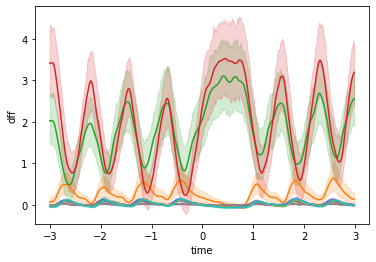

In [17]:
np.random.seed(0)
fig, ax = plt.subplots()
for cell_id in np.random.choice(cell_ids, size=10, replace=False):
    
    make_event_triggered_plot(
        df = neural_data.query('cell_specimen_id == @cell_id'), 
        x = 'time', 
        y = 'dff', 
        event_query = 'omitted', 
        ax=ax
    )

## We can also get the mean response for each of the individual imaging planes in this experiment

In [18]:
# First use Pandas to get the mean response for each experiment
mean_dff_by_experiment = (
    neural_data
    .groupby(['ophys_experiment_id','timestamps'])['dff']
    .mean()
    .reset_index()
)

In [19]:
mean_dff_by_experiment

,ophys_experiment_id,timestamps,dff
0,854759890,10.52216,0.387612
1,854759890,10.61538,0.203569
2,854759890,10.70860,0.035257
3,854759890,10.80182,0.357586
4,854759890,10.89504,0.146397
...,...,...,...
289981,854759903,4517.21002,1.580419
289982,854759903,4517.30327,1.495077
289983,854759903,4517.39653,1.437618
289984,854759903,4517.48979,1.499999


## now iterate through each experiment and plot the mean response

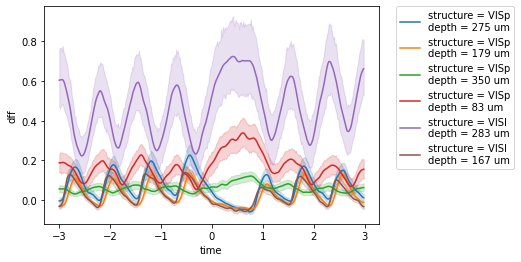

In [20]:
np.random.seed(0)
fig, ax = plt.subplots()
legend_text = []
for ophys_experiment_id in ophys_experiment_ids:
    
    make_event_triggered_plot(
        df = mean_dff_by_experiment.query('ophys_experiment_id == @ophys_experiment_id'), 
        x = 'time', 
        y = 'dff', 
        event_query = 'omitted', 
        ax=ax
    )
    
    this_exp = neural_data.query('ophys_experiment_id == @ophys_experiment_id')
    structure = this_exp['targeted_structure'].iloc[0]
    depth = this_exp['imaging_depth'].iloc[0]
    legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))
    
# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# a quick decoding demo
Can we train a decoder to identify the image identity from dff or event activity?

In [21]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score

### First we're going to build a new tidy dataframe with one row for each stimulus presentation, cell identity and timestep relative to the stimulus
Note that for every distinct stimulus we are only going to gather responses from the stimulus onset time to 0.75 seconds after the stimulus onset.  

In [67]:
# get all unique images, excluding the omissions
image_identities = [im for im in np.sort(stimulus_table['image_name'].unique()) if im != 'omitted']

# set up an empty list that will contain all event triggered responses
full_etr = []

# iterate over every image and cell
for image_index, image_identity in enumerate(image_identities):
    for cell_id in tqdm(neural_data['cell_specimen_id'].unique(), desc = 'image_index {} of {}'.format(image_index+1, len(image_identities))):
        
        # get the event triggered response for all presentations of this image for this cell
        etr = vbu.event_triggered_response(
            neural_data.query('cell_specimen_id == @cell_id'),
            parameter = 'filtered_events',
            event_times = stimulus_table.query('image_name == @image_identity')['start_time'],
            t_before = 0,
            t_after = 0.75,
            sampling_rate = 30 # Note that this is higher than the actual acquisition sampling rate. This just defines the sampling rate for the interpolation routine.
        )
        
        # add a column with the cell_id and the image_identity
        etr['cell_specimen_id'] = cell_id
        etr['image_index'] = image_index
        etr['image_name'] = image_identity
        
        
        # append to the list
        full_etr.append(etr)
     

    # concatenate all dataframes into a single dataframe
full_etr = pd.concat(full_etr)

image_index 8 of 8: 100%|██████████| 53/53 [01:12<00:00,  1.37s/it]


In [68]:
full_etr['event_number'] = full_etr['event_number'].astype(int)

In [69]:
full_etr.query('cell_specimen_id == 1086550481 and image_index == 0 and event_number == 3')

,time,filtered_events,event_number,event_time,cell_specimen_id,image_index,image_name
69,0.000000,0.0,3,312.80242,1086550481,0,im000
70,0.033333,0.0,3,312.80242,1086550481,0,im000
71,0.066667,0.0,3,312.80242,1086550481,0,im000
72,0.100000,0.0,3,312.80242,1086550481,0,im000
73,0.133333,0.0,3,312.80242,1086550481,0,im000
74,0.166667,0.0,3,312.80242,1086550481,0,im000
75,0.200000,0.0,3,312.80242,1086550481,0,im000
76,0.233333,0.0,3,312.80242,1086550481,0,im000
77,0.266667,0.0,3,312.80242,1086550481,0,im000
78,0.300000,0.0,3,312.80242,1086550481,0,im000


## now we have one big dataframe with responses for all cells to the presentation of every image


## Next, we can train a simple Support Vector Machine decoder to try to identify the image based on the vectors of df/f responses that we just built

## First, define some functions to set up the decoder

In [71]:
def organize_data_for_decoder(cell_list, etr):
    '''
    This function will build an X matrix and y vector for the cells in the cell list.

    X will be an N x M matrix where:
        N = the number of events in the etr dataframe
        M = the number of samples surrounding each event * the number of cells in the cell_list

    y will be an N x 1 vector of image indices where:
        N = the number of events in the etr dataframe

    X and y will then be split into training and testing sets

    Parameters:
    -----------
    cell_list : list of strings
        list of cell_ids to include
    etr : Pandas.DataFrame
        event_triggered_response dataframe

    Returns:
    --------
    X_train, X_test, y_train, y_test
    where:
        X_train : Ntrain x M array of floats
        X_test : Ntest x M array of floats
        y_train : Ntrain x 1 array of ints (1 = movement, 0 = no_movement)
        y_test : Ntest x 1 array of ints (1 = movement, 0 = no_movement)
    '''
    image_identities = [im for im in np.sort(etr['image_name'].unique()) if im != 'omitted']

    # set up empty lists of X and y values
    X = []
    y = []
    # iterate over every image
    for image_index, image_identity in enumerate(image_identities):
        # get the event triggered response for this image for all desired cells
        etr_this_image = etr.query('cell_specimen_id in @cell_list and image_name == @image_identity')
        
        # now iterate over every presentation of this image
        for event_number in etr_this_image['event_number'].unique():
            # append the vector of responses to X
            X.append(etr_this_image.query('event_number == @event_number')['filtered_events'].values)
            # and append the image index to y
            y.append(image_index)

    # Now split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    return X_train, X_test, y_train, y_test


def run_svm(X_train, X_test, y_train, y_test):
    '''
    This function will:
        * train the decoder
        * test the decoder on the heldout set of test data
        * evaluate the predictions

    Parameters:
    -----------
    X_train : Ntrain x M array of floats
    X_test : Ntest x M array of floats
    y_train : Ntrain x 1 array of ints (1 = movement, 0 = no_movement)
    y_test : Ntest x 1 array of ints (1 = movement, 0 = no_movement)

    Returns:
    --------
    (model, result) : 
        model : trained sklearn.svm.SVC model
        result : dictionary with keys:
                    'confusion_matrix': model confusion matrix
                    'accuracy': model accuracy
    '''
    
    # instantiate our model
    model = svm.SVC(probability=True)
    
    # fit our model
    model.fit(X_train, y_train)

    # get predictions on the test data
    y_pred = model.predict(X_test)

    # save out the confusion matrix and accuracy
    result = {}
    result['confusion_matrix'] = confusion_matrix(y_test, y_pred)
    result['accuracy'] = accuracy_score(y_test, y_pred)

    return model, result

### Now run the model for each cell individually. This tells us how accurate any given cell is at decoding _all_ images.

In [72]:
cells = {}
for csid in tqdm(neural_data['cell_specimen_id'].unique()):
    cells[csid] = {}
    
    cell_list = [csid]
    
    X_train, X_test, y_train, y_test = organize_data_for_decoder(cell_list, full_etr)
    model, res = run_svm(X_train, X_test, y_train, y_test)
    
    cells[csid]['confusion_matrix'] = res['confusion_matrix']
    cells[csid]['accuracy'] = float(res['accuracy'])

100%|██████████| 53/53 [08:56<00:00, 10.13s/it]


### Organize results into a dataframe

In [73]:
results_df = pd.DataFrame(cells).T
results_df.index.name = 'cell_specimen_id'
results_df

,confusion_matrix,accuracy
cell_specimen_id,,
1086550481,"[[0, 0, 0, 0, 0, 0, 0, 210], [0, 9, 0, 54, 0, ...",0.175082
1086551114,"[[0, 0, 0, 0, 0, 210, 0, 0], [0, 0, 0, 0, 0, 1...",0.236721
1086551301,"[[0, 0, 0, 5, 0, 0, 0, 205], [0, 0, 0, 0, 0, 0...",0.140328
1086557083,"[[10, 0, 0, 0, 15, 0, 0, 185], [0, 0, 0, 0, 1,...",0.165902
1086557639,"[[22, 0, 0, 0, 1, 0, 0, 187], [0, 0, 0, 0, 0, ...",0.146885
1086559064,"[[3, 0, 2, 0, 7, 0, 0, 198], [0, 0, 1, 0, 1, 0...",0.144262
1086558114,"[[0, 0, 0, 0, 0, 1, 5, 204], [1, 0, 0, 0, 0, 0...",0.137049
1086558224,"[[13, 0, 0, 0, 0, 0, 0, 197], [0, 0, 0, 0, 0, ...",0.138361
1086558510,"[[6, 0, 0, 0, 81, 0, 0, 123], [1, 0, 0, 0, 6, ...",0.199344


### and summarize the results

In [74]:
results_df['accuracy'].astype(float).describe()

count    53.000000
mean      0.156239
std       0.024631
min       0.121311
25%       0.140984
50%       0.148852
75%       0.160656
max       0.242623
Name: accuracy, dtype: float64

For an 8-image classification task, chance performance will by 1/8, or 12.5%. We can see that for the models trained on the 53 individual cells in this dataset, the mean accuracy was ~21% and the best model performed at ~29%

### Now run the decoder again, but give it access to the full population.

In [64]:
# define the cell list to include all cells
cell_list = list(full_etr['cell_specimen_id'].unique())

# get our train/test data
X_train, X_test, y_train, y_test = organize_data_for_decoder(cell_list, full_etr)
# Run the model
model, res = run_svm(X_train, X_test, y_train, y_test)

The model trained on the full model performs with ~74% accuracy:

In [65]:
res['accuracy']

0.5291803278688525

And here is the full confusion matrix:

In [66]:
pd.DataFrame(
    res['confusion_matrix'], 
    columns = ['predicted_{}'.format(im) for im in image_identities],
    index = ['actual_{}'.format(im) for im in image_identities]
)

,predicted_im000,predicted_im031,predicted_im035,predicted_im045,predicted_im054,predicted_im073,predicted_im075,predicted_im106
actual_im000,89,73,11,2,23,12,0,0
actual_im031,2,135,7,3,17,10,0,0
actual_im035,4,104,63,2,12,12,2,1
actual_im045,4,36,3,136,7,5,0,1
actual_im054,47,68,5,0,72,12,1,0
actual_im073,14,75,9,7,14,52,0,0
actual_im075,2,49,2,2,11,9,97,0
actual_im106,1,21,5,0,5,4,2,163


In [37]:
y_train_shuffle = y_train.copy()
np.random.shuffle(y_train_shuffle)

# Run the model
model, res = run_svm(X_train, X_test, y_train_shuffle, y_test)

In [38]:
res['accuracy']

0.05639344262295082

In [39]:
pd.DataFrame(
    res['confusion_matrix'], 
    columns = ['predicted_{}'.format(im) for im in image_identities],
    index = ['actual_{}'.format(im) for im in image_identities]
)

,predicted_im000,predicted_im031,predicted_im035,predicted_im045,predicted_im054,predicted_im073,predicted_im075,predicted_im106
actual_im000,1,5,0,12,0,13,12,167
actual_im031,4,3,4,14,5,15,11,118
actual_im035,2,2,0,9,14,10,15,148
actual_im045,9,3,1,5,2,9,20,143
actual_im054,2,4,7,32,1,18,11,130
actual_im073,4,1,1,4,3,11,21,126
actual_im075,1,10,1,8,0,71,13,68
actual_im106,86,4,5,28,6,13,7,52


In [41]:
4800/8/3

200.0